In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import os
from collections import defaultdict
from itertools import permutations
from phase2_utils import build_hybrid_compatibility_matrix

%matplotlib inline

## 1. Configuration

In [3]:
# Puzzle types to process
PUZZLE_TYPES = ["puzzle_2x2", "puzzle_4x4", "puzzle_8x8"]
BASE_DIR = "./processed_artifacts"

# Process every Nth image for testing (set to None to process all)
PROCESS_EVERY_N = 20

print("Phase 2 Pipeline Configuration:")
print(f"Puzzle types: {PUZZLE_TYPES}")
print(f"Base directory: {BASE_DIR}")
print(f"Processing mode: Every {PROCESS_EVERY_N} images" if PROCESS_EVERY_N else "Processing mode: All images")

Phase 2 Pipeline Configuration:
Puzzle types: ['puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']
Base directory: ./processed_artifacts
Processing mode: Every 20 images


## 2. Define Assembly Algorithms

In [4]:
from phase2_utils import assemble_puzzle_best_first

def assemble_exhaustive_2x2(compatibility):
    """
    Exhaustive search for optimal 2x2 arrangement.
    Tests all 24 permutations and selects the best.
    """
    best_score = -np.inf
    best_arrangement = None
    
    for perm in permutations([0, 1, 2, 3]):
        total_score = 0
        
        # Horizontal relationships
        total_score += compatibility[perm[0]][perm[1]]['right']
        total_score += compatibility[perm[1]][perm[0]]['left']
        total_score += compatibility[perm[2]][perm[3]]['right']
        total_score += compatibility[perm[3]][perm[2]]['left']
        
        # Vertical relationships
        total_score += compatibility[perm[0]][perm[2]]['bottom']
        total_score += compatibility[perm[2]][perm[0]]['top']
        total_score += compatibility[perm[1]][perm[3]]['bottom']
        total_score += compatibility[perm[3]][perm[1]]['top']
        
        if total_score > best_score:
            best_score = total_score
            best_arrangement = perm
    
    grid = np.array([[best_arrangement[0], best_arrangement[1]],
                     [best_arrangement[2], best_arrangement[3]]])
    return grid, best_score


def create_assembled_image(grid, patches):
    """Reconstruct full image from assembled grid."""
    grid_size = grid.shape[0]
    
    if len(patches[0].shape) == 3:
        patch_h, patch_w, channels = patches[0].shape
        assembled = np.zeros((grid_size * patch_h, grid_size * patch_w, channels), dtype=np.uint8)
    else:
        patch_h, patch_w = patches[0].shape
        assembled = np.zeros((grid_size * patch_h, grid_size * patch_w), dtype=np.uint8)
    
    for row in range(grid_size):
        for col in range(grid_size):
            piece_idx = grid[row, col]
            if piece_idx >= 0:
                y_start = row * patch_h
                y_end = (row + 1) * patch_h
                x_start = col * patch_w
                x_end = (col + 1) * patch_w
                assembled[y_start:y_end, x_start:x_end] = patches[piece_idx]
    
    return assembled

print("Assembly algorithms defined.")

ImportError: cannot import name 'assemble_puzzle_best_first' from 'phase2_utils' (c:\Users\MONTASER YOUSUF\Documents\Image-Processing-Project\phase2_utils.py)

## 3. Process All Puzzles

In [ ]:
# Load all puzzles from Phase 1 artifacts
all_puzzles = []

for puzzle_type in PUZZLE_TYPES:
    puzzle_dir = os.path.join(BASE_DIR, puzzle_type)
    
    if not os.path.exists(puzzle_dir):
        print(f"Warning: {puzzle_dir} not found, skipping...")
        continue
    
    # Find all image folders
    image_folders = [f for f in os.listdir(puzzle_dir) if f.startswith('image_')]
    image_folders.sort()
    
    # Apply sampling if configured
    if PROCESS_EVERY_N:
        sampled_folders = [image_folders[i] for i in range(0, len(image_folders), PROCESS_EVERY_N)]
        print(f"\nLoading {puzzle_type}: {len(sampled_folders)} of {len(image_folders)} images (every {PROCESS_EVERY_N})")
        image_folders = sampled_folders
    else:
        print(f"\nLoading {puzzle_type}: {len(image_folders)} images")
    
    for image_folder in image_folders:
        artifact_dir = os.path.join(puzzle_dir, image_folder)
        metadata_path = os.path.join(artifact_dir, 'metadata.json')
        
        if not os.path.exists(metadata_path):
            continue
        
        # Load metadata
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        grid_size = metadata['grid_size']
        num_pieces = metadata['num_pieces']
        image_id = image_folder.split('_')[1]
        
        # Load original image and split into patches
        original_img = cv2.imread(metadata['image_path'])
        if original_img is None:
            print(f"  Warning: Could not load {metadata['image_path']}, skipping...")
            continue
        original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        height, width = original_rgb.shape[:2]
        patch_h = height // grid_size
        patch_w = width // grid_size
        
        original_patches = []
        for i in range(num_pieces):
            row = i // grid_size
            col = i % grid_size
            patch = original_rgb[row*patch_h:(row+1)*patch_h, col*patch_w:(col+1)*patch_w]
            original_patches.append(patch)
        
        # Load edge images from Phase 1
        edge_images = []
        for i in range(num_pieces):
            edge_path = os.path.join(artifact_dir, 'edge_images', f'piece_{i:02d}_edges.png')
            edge_img = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)
            edge_images.append(edge_img)
        
        all_puzzles.append({
            'puzzle_type': puzzle_type,
            'image_id': image_id,
            'grid_size': grid_size,
            'num_pieces': num_pieces,
            'original_patches': original_patches,
            'edge_images': edge_images,
            'artifact_dir': artifact_dir
        })

print(f"\n{'='*60}")
print(f"Total puzzles loaded: {len(all_puzzles)}")
print('='*60)


Loading puzzle_2x2: 6 of 110 images (every 20)

Loading puzzle_4x4: 6 of 110 images (every 20)

Loading puzzle_8x8: 6 of 110 images (every 20)

Total puzzles loaded: 18

Total puzzles loaded: 18


## 4. Assemble All Puzzles

In [ ]:
print("Starting puzzle assembly...\n")

for idx, puzzle in enumerate(all_puzzles):
    print(f"[{idx+1}/{len(all_puzzles)}] {puzzle['puzzle_type']} - Image {puzzle['image_id']}...", end=' ')
    
    # Build hybrid compatibility matrix
    compatibility = build_hybrid_compatibility_matrix(
        puzzle['edge_images'],
        puzzle['original_patches']
    )
    
    # Assemble based on puzzle size
    if puzzle['grid_size'] == 2:
        # Use exhaustive search for 2x2 (optimal)
        assembled_grid, score = assemble_exhaustive_2x2(compatibility)
    else:
        # Use best-first for 4x4 and 8x8
        assembled_grid = assemble_puzzle_best_first(
            puzzle['num_pieces'],
            puzzle['grid_size'],
            compatibility
        )
        # Calculate score for the assembled grid
        score = 0.0
        for r in range(puzzle['grid_size']):
            for c in range(puzzle['grid_size']):
                piece = assembled_grid[r, c]
                if c < puzzle['grid_size'] - 1:
                    neighbor = assembled_grid[r, c+1]
                    score += compatibility[piece][neighbor]['right']
                if r < puzzle['grid_size'] - 1:
                    neighbor = assembled_grid[r+1, c]
                    score += compatibility[piece][neighbor]['bottom']
    
    puzzle['assembled_grid'] = assembled_grid
    puzzle['assembly_score'] = score
    puzzle['compatibility'] = compatibility
    
    print(f"DONE (score: {score:.4f})")

print(f"\n{'='*60}")
print("Assembly complete!")
print('='*60)

Starting puzzle assembly...

[1/18] puzzle_2x2 - Image 0... DONE (score: 4.0391)
[2/18] puzzle_2x2 - Image 18... DONE (score: 4.0972)
[3/18] puzzle_2x2 - Image 36... DONE (score: 4.9623)
[4/18] puzzle_2x2 - Image 54... DONE (score: 4.0972)
[3/18] puzzle_2x2 - Image 36... DONE (score: 4.9623)
[4/18] puzzle_2x2 - Image 54... DONE (score: 4.7422)
[5/18] puzzle_2x2 - Image 72... DONE (score: 3.9777)
[6/18] puzzle_2x2 - Image 90... DONE (score: 4.7422)
[5/18] puzzle_2x2 - Image 72... DONE (score: 3.9777)
[6/18] puzzle_2x2 - Image 90... DONE (score: 4.0769)
[7/18] puzzle_4x4 - Image 0... DONE (score: 4.0769)
[7/18] puzzle_4x4 - Image 0... DONE (score: 8.3867)
[8/18] puzzle_4x4 - Image 18... DONE (score: 8.3867)
[8/18] puzzle_4x4 - Image 18... DONE (score: 7.6832)
[9/18] puzzle_4x4 - Image 36... DONE (score: 7.6832)
[9/18] puzzle_4x4 - Image 36... DONE (score: 12.3320)
[10/18] puzzle_4x4 - Image 54... DONE (score: 12.3320)
[10/18] puzzle_4x4 - Image 54... DONE (score: 12.0922)
[11/18] puzzle_

## 5. Visualize Results

Visualizing 18 assembled puzzles...


PUZZLE_2X2 - 6 puzzles


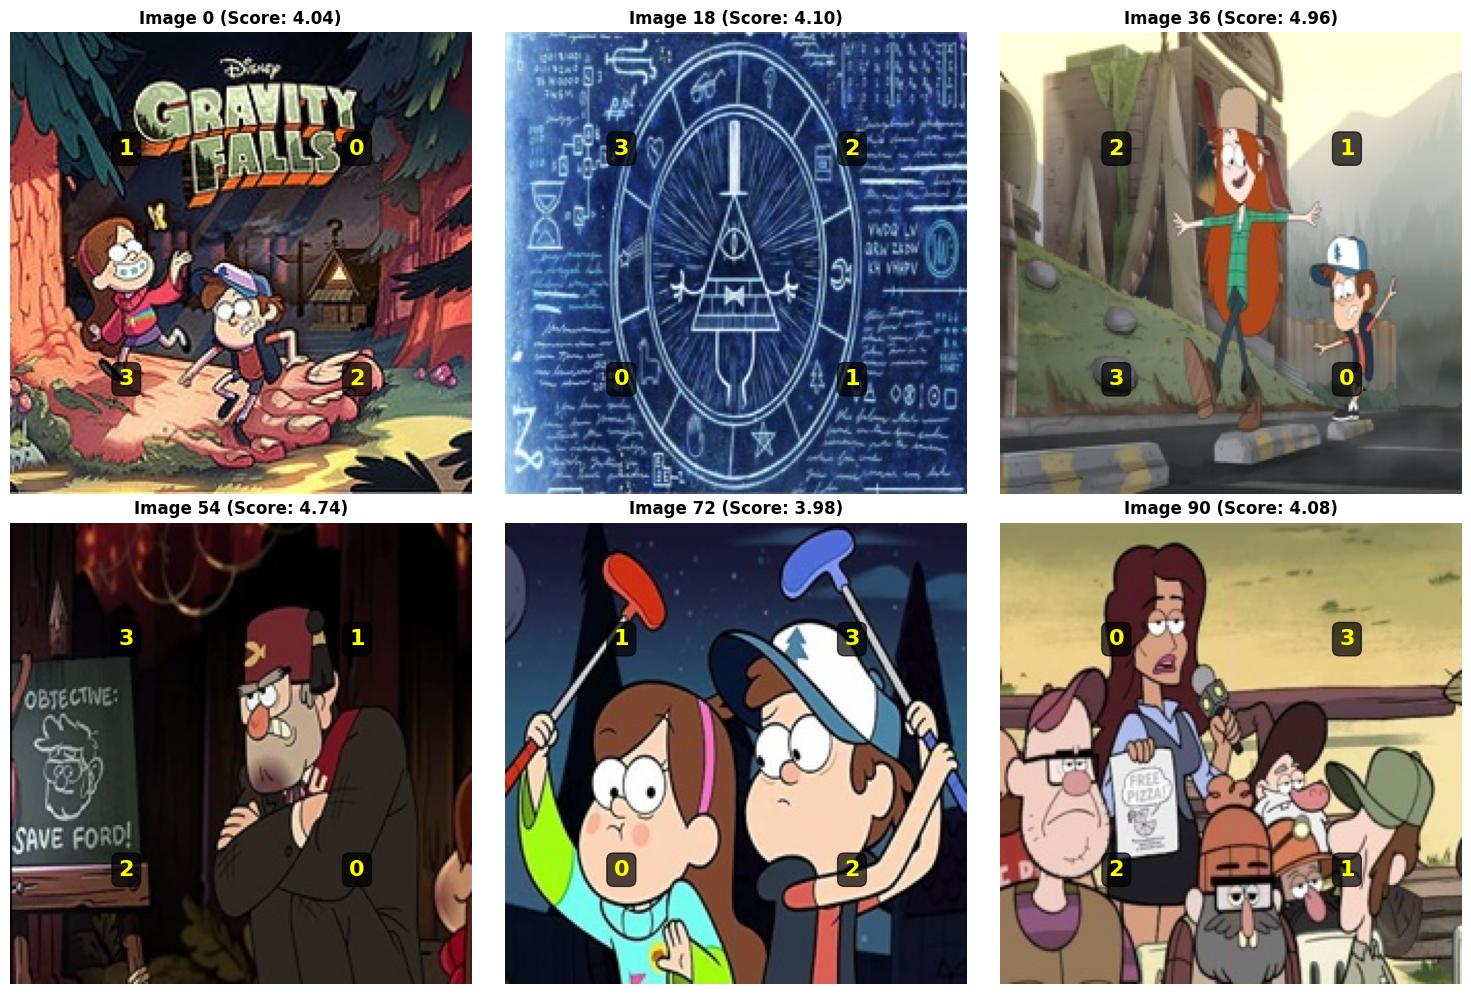


PUZZLE_4X4 - 6 puzzles


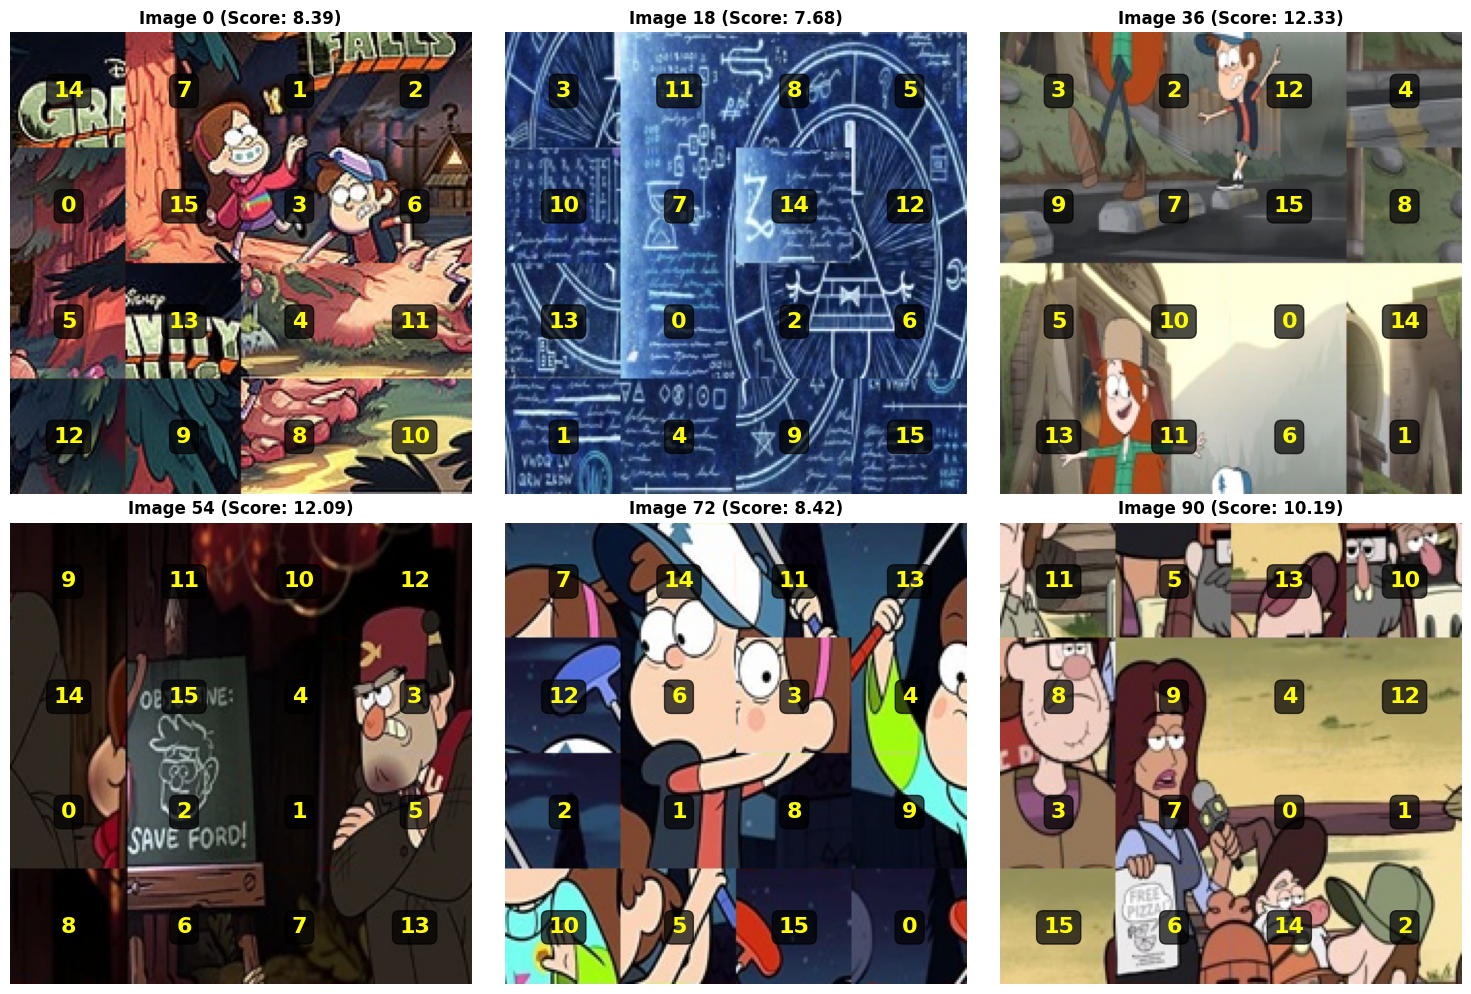


PUZZLE_8X8 - 6 puzzles


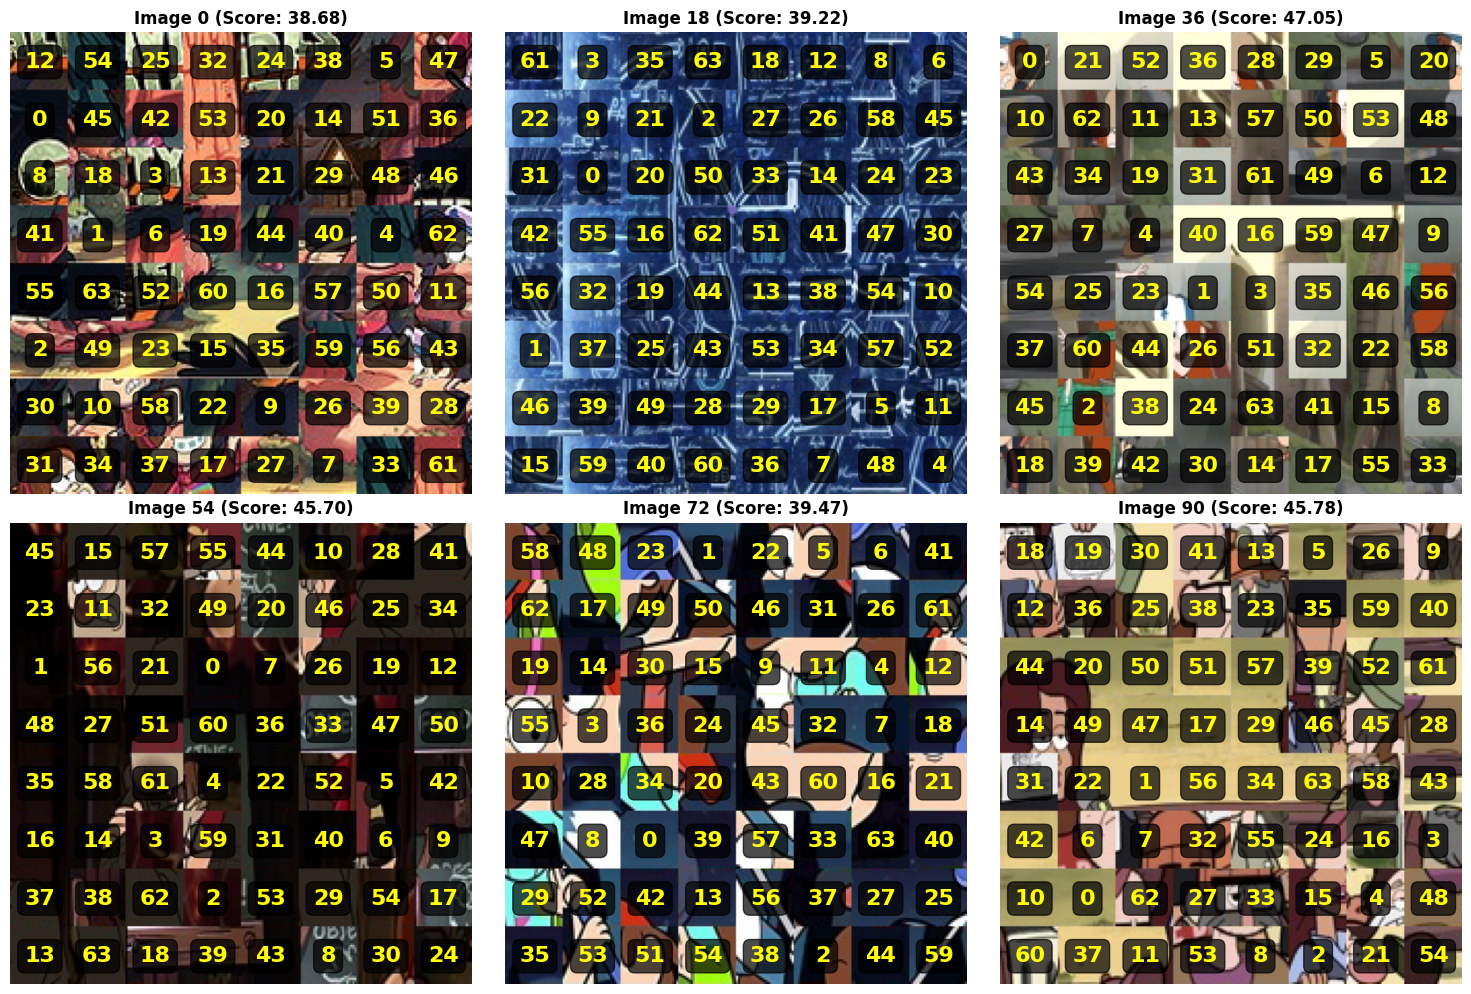

In [ ]:
# Filter only assembled puzzles
assembled_puzzles = [p for p in all_puzzles if p['assembled_grid'] is not None]

print(f"Visualizing {len(assembled_puzzles)} assembled puzzles...\n")

# Group by puzzle type
for puzzle_type in PUZZLE_TYPES:
    puzzles_of_type = [p for p in assembled_puzzles if p['puzzle_type'] == puzzle_type]
    
    if not puzzles_of_type:
        continue
    
    print(f"\n{'='*60}")
    print(f"{puzzle_type.upper()} - {len(puzzles_of_type)} puzzles")
    print('='*60)
    
    # Create grid of visualizations
    num_puzzles = len(puzzles_of_type)
    cols = 3
    rows = (num_puzzles + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, puzzle in enumerate(puzzles_of_type):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Create assembled image
        assembled_image = create_assembled_image(
            puzzle['assembled_grid'],
            puzzle['original_patches']
        )
        
        # Display
        ax.imshow(assembled_image)
        ax.set_title(f"Image {puzzle['image_id']} (Score: {puzzle['assembly_score']:.2f})",
                    fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Add piece labels
        for r in range(puzzle['grid_size']):
            for c in range(puzzle['grid_size']):
                piece_idx = puzzle['assembled_grid'][r, c]
                patch_h, patch_w = puzzle['original_patches'][0].shape[:2]
                y = (r + 0.5) * patch_h
                x = (c + 0.5) * patch_w
                ax.text(x, y, str(piece_idx),
                       color='yellow', fontsize=16, fontweight='bold',
                       ha='center', va='center',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    # Hide unused subplots
    for idx in range(num_puzzles, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

## 6. Save Results Summary

In [ ]:
# Generate summary report
summary = {
    'total_puzzles': len(all_puzzles),
    'assembled_puzzles': len(assembled_puzzles),
    'by_type': {}
}

for puzzle_type in PUZZLE_TYPES:
    puzzles_of_type = [p for p in assembled_puzzles if p['puzzle_type'] == puzzle_type]
    
    if puzzles_of_type:
        scores = [p['assembly_score'] for p in puzzles_of_type]
        summary['by_type'][puzzle_type] = {
            'count': len(puzzles_of_type),
            'avg_score': float(np.mean(scores)),
            'min_score': float(np.min(scores)),
            'max_score': float(np.max(scores)),
            'results': [
                {
                    'image_id': p['image_id'],
                    'assembled_grid': p['assembled_grid'].tolist(),
                    'score': float(p['assembly_score'])
                }
                for p in puzzles_of_type
            ]
        }

# Save summary
summary_path = os.path.join(BASE_DIR, 'phase2_assembly_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n{'='*60}")
print("PHASE 2 ASSEMBLY SUMMARY")
print('='*60)
print(f"Total puzzles processed: {summary['total_puzzles']}")
print(f"Successfully assembled: {summary['assembled_puzzles']}")
print()

for puzzle_type, stats in summary['by_type'].items():
    print(f"\n{puzzle_type}:")
    print(f"  Count: {stats['count']}")
    print(f"  Avg Score: {stats['avg_score']:.4f}")
    print(f"  Score Range: [{stats['min_score']:.4f}, {stats['max_score']:.4f}]")

print(f"\nResults saved to: {summary_path}")
print('='*60)


PHASE 2 ASSEMBLY SUMMARY
Total puzzles processed: 18
Successfully assembled: 18


puzzle_2x2:
  Count: 6
  Avg Score: 4.3159
  Score Range: [3.9777, 4.9623]

puzzle_4x4:
  Count: 6
  Avg Score: 9.8499
  Score Range: [7.6832, 12.3320]

puzzle_8x8:
  Count: 6
  Avg Score: 42.6503
  Score Range: [38.6829, 47.0471]

Results saved to: ./processed_artifacts\phase2_assembly_summary.json
